In [1]:
# Uso de GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Detalles:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Detalles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Importaciones generales
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, VGG16, MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Configuraciones globales
BASE_DIR = r'C:\Users\oicas\OneDrive\Desktop\Intro a las App de Algoritmos de ML y DL\Proyecto\Dataset\dataset_proyecto_final'
IMG_SIZE = 224 #
BATCH_SIZE = 64 #32, 64 o 128
SEED = 42 #

C:\Users\oicas\AppData\Local\Temp\ipykernel_17340\1186024139.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


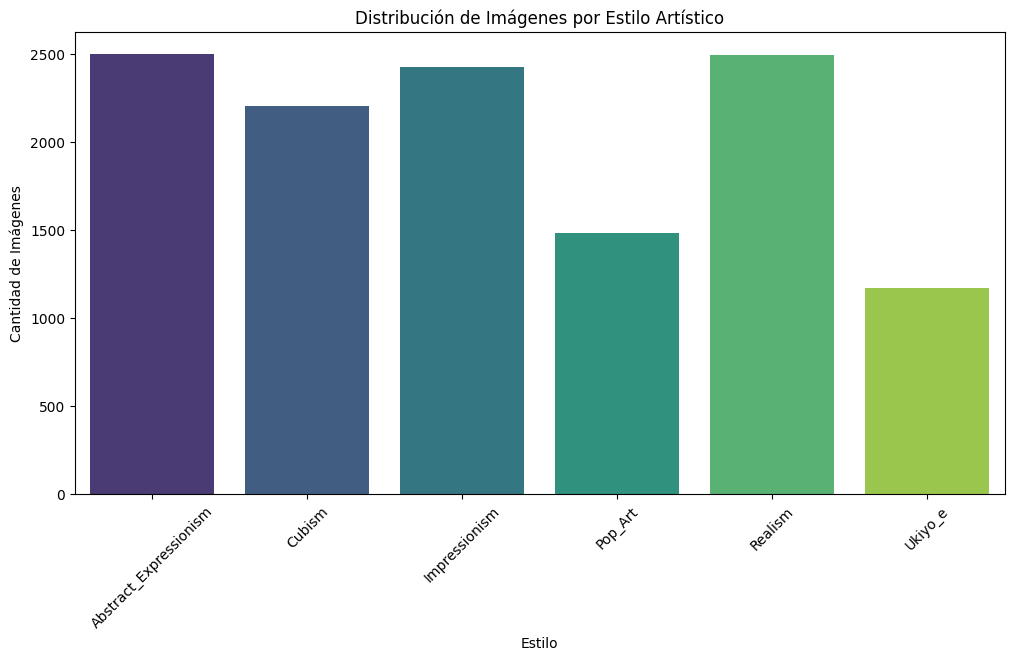

Total de clases: 6
Total de imágenes: 12274


In [4]:
# Análisis de la distribución de clases
classes = os.listdir(BASE_DIR)
counts = []

for c in classes:
    path = os.path.join(BASE_DIR, c)
    if os.path.isdir(path):
        counts.append(len(os.listdir(path)))

# Visualizacion de la distribución
plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Distribución de Imágenes por Estilo Artístico")
plt.xlabel("Estilo")
plt.ylabel("Cantidad de Imágenes")
plt.xticks(rotation=45)
plt.show()

# Resumen de la distribución
print(f"Total de clases: {len(classes)}")
print(f"Total de imágenes: {sum(counts)}")

In [5]:
# Generadores para Deep Learning (Con Augmentation y Shuffle)
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.3, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=0.2
)

# Entrenamiento
print("\nGenerando datasets de entrenamiento")
train_generator = train_datagen.flow_from_directory(
    BASE_DIR, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='training', 
    seed=SEED, 
    shuffle=True
)

# Validación
validation_generator = train_datagen.flow_from_directory(
    BASE_DIR, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='validation', 
    seed=SEED, 
    shuffle=False # No shuffle para evaluación
)

# Mostrar las clases
class_names = list(train_generator.class_indices.keys())
print(f"Clases: {class_names}")

# Pesos de clase
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de clase: {class_weights_dict}")


Generando datasets de entrenamiento
Found 9822 images belonging to 6 classes.
Found 2452 images belonging to 6 classes.
Clases: ['Abstract_Expressionism', 'Cubism', 'Impressionism', 'Pop_Art', 'Realism', 'Ukiyo_e']
Pesos de clase: {0: 0.8185, 1: 0.9285309132161089, 2: 0.8429454170957775, 3: 1.37910699241786, 4: 0.8201402805611222, 5: 1.7526766595289078}


In [6]:
# Grafica las curvas de aprendizaje (Loss y Accuracy)
def plot_training_history(history, titulo):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
    plt.title(f'{titulo} - Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
    plt.title(f'{titulo} - Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.show()

# Mostrar matriz de confusión y reporte de clasificación
def mostrar_matriz_confusion(y_true, y_pred, clases, titulo):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=clases, 
        yticklabels=clases
    )
    plt.title(f'Matriz de Confusión: {titulo}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
    
    print(f"\n--- Reporte de Clasificación: {titulo} ---")
    print(classification_report(y_true, y_pred, target_names=clases))

# Visualización de predicciones del modelo
def visualizar_predicciones(model, generator, clases, num_img=5):
    # Tomar un batch
    imgs, labels = next(generator)
    preds = model.predict(imgs, verbose=0)
    
    plt.figure(figsize=(15, 5))
    for i in range(num_img):
        plt.subplot(1, num_img, i+1)
        plt.imshow(imgs[i])
        
        # Índices de clase
        real_idx = np.argmax(labels[i])
        pred_idx = np.argmax(preds[i])
        
        color = 'green' if real_idx == pred_idx else 'red'
        
        plt.title(f"Real: {clases[real_idx]}\nPred: {clases[pred_idx]}", color=color)
        plt.axis('off')
    plt.suptitle("Ejemplos de Predicciones")
    plt.show()

# Evaluar y mostrar matriz de confusión
def evaluar_y_mostrar_matriz(model, generator, class_names, titulo):
    # Reiniciar generador y asegurar orden
    generator.reset()
    generator.shuffle = False # Asegurar que no mezcle
    
    # Predecir
    y_pred_prob = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes
    
    # Matriz
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'Matriz de Confusión: {titulo}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    
    # Reporte numérico
    print(f"--- Reporte {titulo} ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    # generator.shuffle = True 

In [7]:
# Funciones construcoras de modelos
# Descarga de las bases modelos
def obtener_backbone(nombre, input_shape):
    if nombre == 'resnet50': 
        return ResNet50V2(
            weights='imagenet', 
            include_top=False, 
            input_shape=input_shape
        )
    elif nombre == 'vgg16': 
        return VGG16(
            weights='imagenet', 
            include_top=False, 
            input_shape=input_shape
        )
    elif nombre == 'mobilenet': 
        return MobileNetV2(
            weights='imagenet', 
            include_top=False, 
            input_shape=input_shape
        )
    else: raise ValueError(f"Modelo {nombre} no soportado")

# Construcción del modelo completo
def construir_modelo(
        nombre_backbone, 
        num_clases, 
        dropout_rate=0.5, 
        learning_rate=0.001
    ):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    # Base
    base_model = obtener_backbone(nombre_backbone, input_shape)
    base_model.trainable = False # Congelar la base preentrenada
    
    # Cabeza
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout_rate),
        Dense(256, activation='relu', 
        kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate / 2),
        Dense(num_clases, activation='softmax')
    ])

    # Compilación
    model.compile(optimizer=Adam(learning_rate), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model, base_model

In [8]:
# Registro de resultados
resultados_globales = []
best_base_acc = 0.0
best_backbone_name = ""

FASE 1: Comparativa de Arquitecturas

Evaluando Arquitectura: MOBILENET
Epoch 1/17
154/154 [==============================] - 227s 1s/step - loss: 3.8405 - accuracy: 0.5261 - val_loss: 2.4218 - val_accuracy: 0.6109
Epoch 2/17
154/154 [==============================] - 225s 1s/step - loss: 1.9423 - accuracy: 0.6129 - val_loss: 1.5769 - val_accuracy: 0.6370
Epoch 3/17
154/154 [==============================] - 231s 1s/step - loss: 1.4564 - accuracy: 0.6122 - val_loss: 1.3274 - val_accuracy: 0.6321
Epoch 4/17
154/154 [==============================] - 233s 2s/step - loss: 1.2887 - accuracy: 0.6212 - val_loss: 1.2063 - val_accuracy: 0.6521
Epoch 5/17
154/154 [==============================] - 236s 2s/step - loss: 1.2198 - accuracy: 0.6236 - val_loss: 1.2209 - val_accuracy: 0.6244
Epoch 6/17
154/154 [==============================] - 287s 2s/step - loss: 1.1890 - accuracy: 0.6247 - val_loss: 1.1811 - val_accuracy: 0.6415
Epoch 7/17
154/154 [==============================] - 160s 1s/step - l

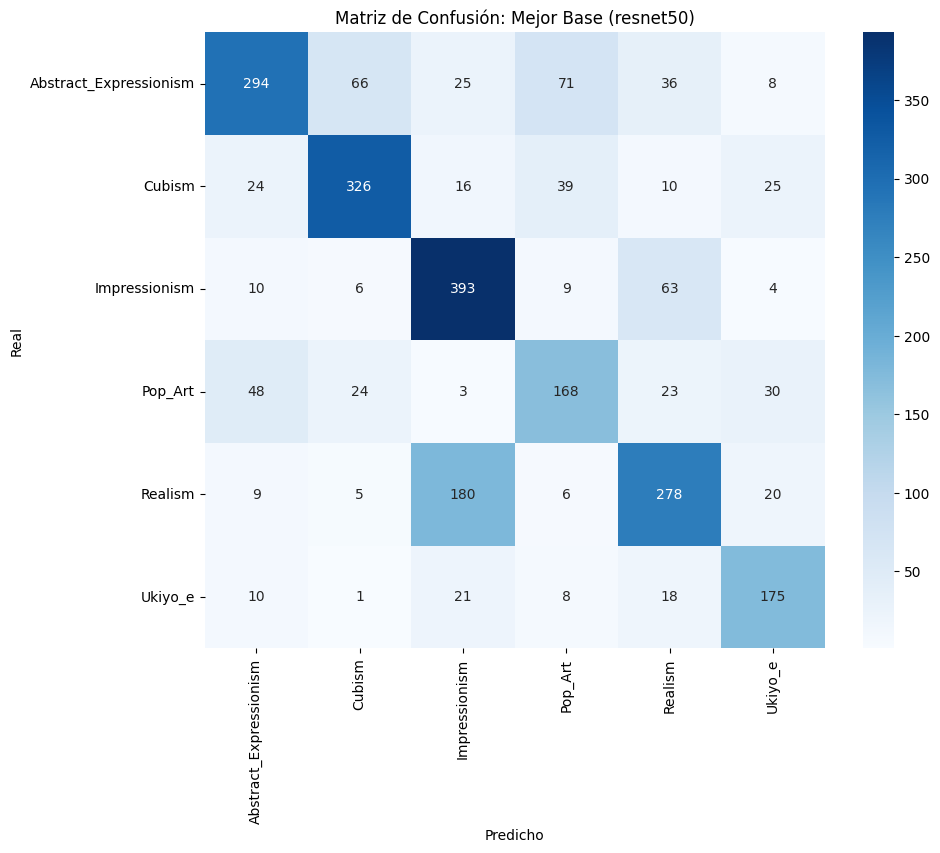

--- Reporte Mejor Base (resnet50) ---
                        precision    recall  f1-score   support

Abstract_Expressionism       0.74      0.59      0.66       500
                Cubism       0.76      0.74      0.75       440
         Impressionism       0.62      0.81      0.70       485
               Pop_Art       0.56      0.57      0.56       296
               Realism       0.65      0.56      0.60       498
               Ukiyo_e       0.67      0.75      0.71       233

              accuracy                           0.67      2452
             macro avg       0.67      0.67      0.66      2452
          weighted avg       0.67      0.67      0.66      2452



In [9]:
print("FASE 1: Comparativa de Arquitecturas")

candidatos = ['mobilenet', 'vgg16', 'resnet50']
best_base_acc = 0.0
best_backbone_name = ""

# Evaluación de cada arquitectura
for backbone in candidatos:
    print(f"\nEvaluando Arquitectura: {backbone.upper()}")
    tf.keras.backend.clear_session()
    
    # Construcción del modelo
    model, _ = construir_modelo(
        backbone, 
        len(class_names), 
        dropout_rate=0.5
    )
    
    # Entrenamiento
    start_t = time.time()
    hist = model.fit(
        train_generator, 
        epochs=17, 
        validation_data=validation_generator,
        class_weight=class_weights_dict, 
        verbose=1 # Mostrar progreso
    )

    # Curvas de aprendizaje
    acc = hist.history['val_accuracy'][-1]
    dur = time.time() - start_t
    
    # Guardar cada modelo
    nombre_archivo = f"temp_{backbone}_base.keras"
    model.save(nombre_archivo)
    
    # Registro de resultados
    resultados_globales.append({
        'Modelo': f"{backbone}_Base", 
        'Etapa': '1. Selección', 
        'Accuracy': acc, 
        'Tiempo': dur
    })
    
    # Curvas de aprendizaje
    if acc > best_base_acc:
        best_base_acc = acc
        best_backbone_name = backbone

print(f"\nMejor Modelo Base: {best_backbone_name} con {best_base_acc:.2%}")

# Generar matriz de confusión del mejor modelo base
print(f"\nMatriz del Mejor Modelo Base ({best_backbone_name})")
tf.keras.backend.clear_session()
best_base_model = load_model(f"temp_{best_backbone_name}_base.keras")
evaluar_y_mostrar_matriz(
    best_base_model, 
    validation_generator, 
    class_names, 
    f"Mejor Base ({best_backbone_name})"
)


FASE 2: Fine-Tuning al Mejor Resultado (resnet50)
Epoch 1/17
154/154 [==============================] - 278s 2s/step - loss: 1.2153 - accuracy: 0.6298 - val_loss: 1.1511 - val_accuracy: 0.6660
Epoch 2/17
154/154 [==============================] - 287s 2s/step - loss: 1.0842 - accuracy: 0.6761 - val_loss: 1.1192 - val_accuracy: 0.6688
Epoch 3/17
154/154 [==============================] - 289s 2s/step - loss: 1.0128 - accuracy: 0.6953 - val_loss: 1.0768 - val_accuracy: 0.6860
Epoch 4/17
154/154 [==============================] - 289s 2s/step - loss: 0.9665 - accuracy: 0.7169 - val_loss: 1.0510 - val_accuracy: 0.6913
Epoch 5/17
154/154 [==============================] - 289s 2s/step - loss: 0.9295 - accuracy: 0.7283 - val_loss: 1.0357 - val_accuracy: 0.6921
Epoch 6/17
154/154 [==============================] - 300s 2s/step - loss: 0.8915 - accuracy: 0.7403 - val_loss: 1.0252 - val_accuracy: 0.7064
Epoch 7/17
154/154 [==============================] - 276s 2s/step - loss: 0.8556 - accurac

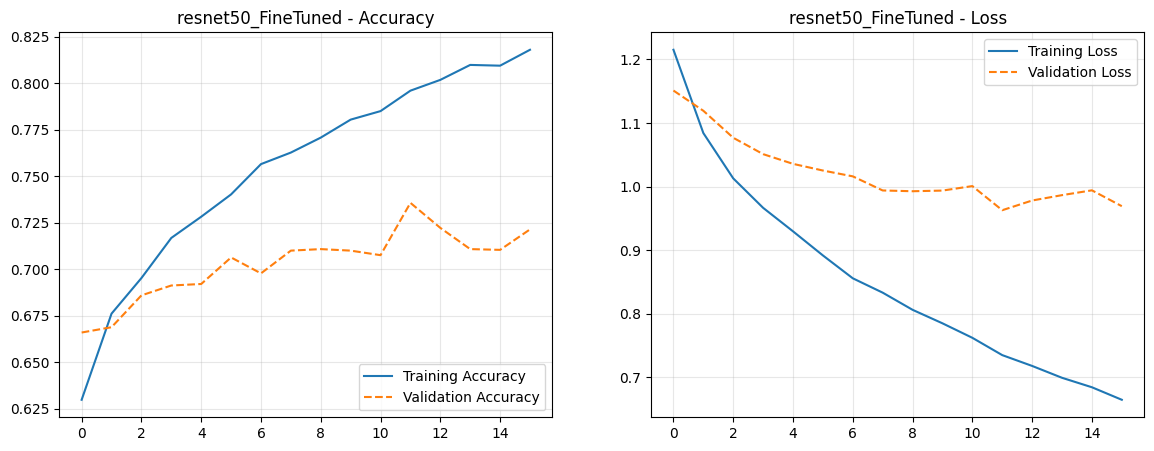

Modelo guardado: temp_resnet50_finetuned.keras
39/39 [==============================] - 58s 1s/step


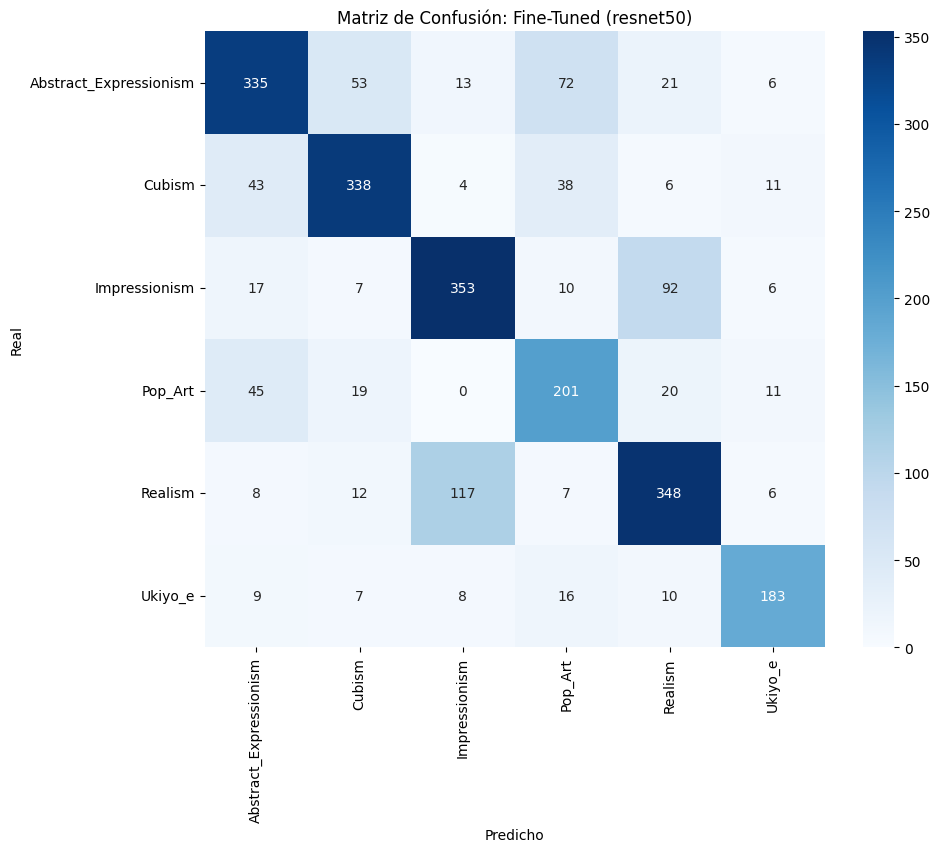

--- Reporte Fine-Tuned (resnet50) ---
                        precision    recall  f1-score   support

Abstract_Expressionism       0.73      0.67      0.70       500
                Cubism       0.78      0.77      0.77       440
         Impressionism       0.71      0.73      0.72       485
               Pop_Art       0.58      0.68      0.63       296
               Realism       0.70      0.70      0.70       498
               Ukiyo_e       0.82      0.79      0.80       233

              accuracy                           0.72      2452
             macro avg       0.72      0.72      0.72      2452
          weighted avg       0.72      0.72      0.72      2452

Fine-Tuning mejoró el modelo.


In [10]:
print(f"\nFASE 2: Fine-Tuning al Mejor Resultado ({best_backbone_name})")
tf.keras.backend.clear_session()
model_campeon = load_model(f"temp_{best_backbone_name}_base.keras")

# Descongelar base (capa 0)
base_inner = model_campeon.layers[0]
base_inner.trainable = True
limit = int(len(base_inner.layers) * 0.8)
for layer in base_inner.layers[:limit]: layer.trainable = False

# Compilación con tasa de aprendizaje baja
model_campeon.compile(
    optimizer=Adam(1e-5), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Entrenamiento con Early Stopping
start_t = time.time()
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True
)

# Entrenamiento
hist_ft = model_campeon.fit(
    train_generator, 
    epochs=17, 
    validation_data=validation_generator,
    class_weight=class_weights_dict, 
    callbacks=[early_stop], 
    verbose=1
)
ft_acc = hist_ft.history['val_accuracy'][-1]
dur = time.time() - start_t

# Graficar Fine Tuning
plot_training_history(
    hist_ft, 
    f"{best_backbone_name}_FineTuned"
)

# Guardar modelo Fine-Tuned
nombre_ft = f"temp_{best_backbone_name}_finetuned.keras"
model_campeon.save(nombre_ft)
print(f"Modelo guardado: {nombre_ft}")

# Matriz de confusión del modelo Fine-Tuned
evaluar_y_mostrar_matriz(
    model_campeon, 
    validation_generator, 
    class_names, 
    f"Fine-Tuned ({best_backbone_name})"
)

# Registro de resultados de Fine-Tuning
resultados_globales.append({
    'Modelo': f"{best_backbone_name}_FineTuned", 
    'Etapa': '2. Optimización', 
    'Accuracy': ft_acc, 
    'Tiempo': dur
})

# Decisión del nuevo mejor resultado para híbrido
if ft_acc > best_base_acc:
    modelo_final_dl = model_campeon
    nombre_final = f"{best_backbone_name}_FineTuned"
    print(f"Fine-Tuning mejoró el modelo.")
else:
    modelo_final_dl = load_model(f"temp_{best_backbone_name}_base.keras")
    nombre_final = f"{best_backbone_name}_Base"
    print(f"Fine-Tuning no mejoró significativamente.")


Ejemplos visuales del modelo Fine-Tuned:


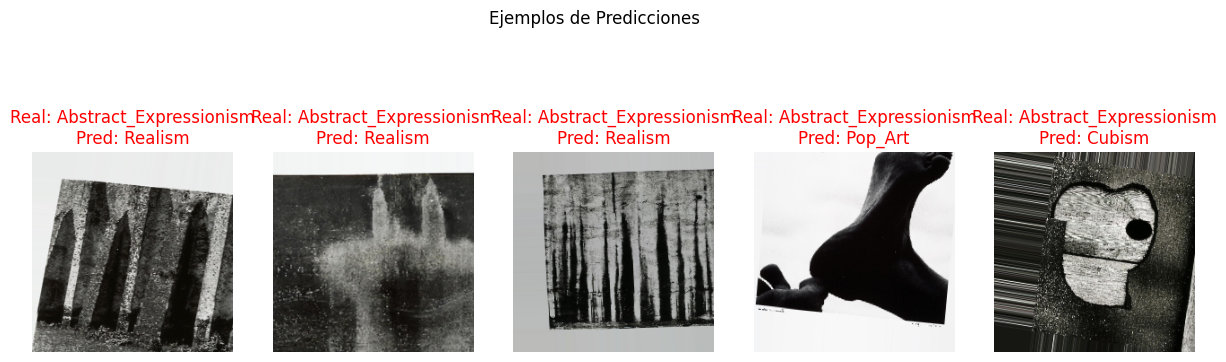

In [11]:
# Ver predicciones visuales
print("\nEjemplos visuales del modelo Fine-Tuned:")
visualizar_predicciones(
    model_campeon, 
    validation_generator, 
    class_names
)


FASE 3: Modelos Hibridos (Usando 'resnet50_FineTuned' como extractor)
Found 9822 images belonging to 6 classes.
Found 2452 images belonging to 6 classes.
39/39 [==============================] - 48s 1s/step
Entrenando SVM_RBF
Resultados para SVM_RBF:


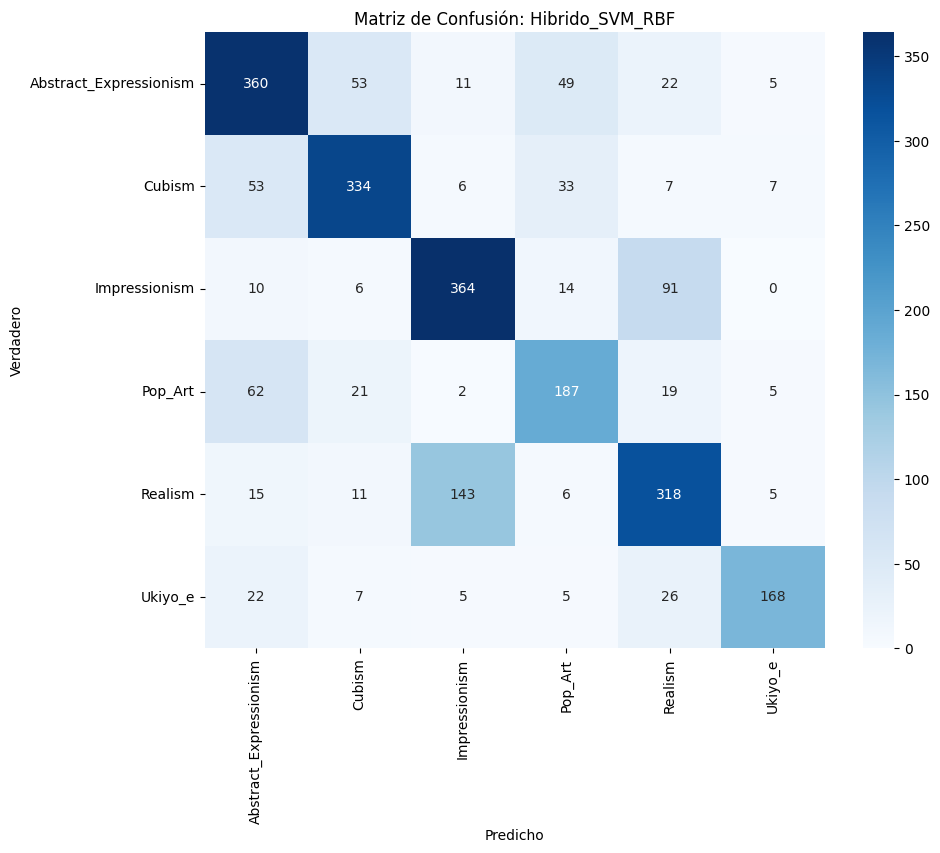


--- Reporte de Clasificación: Hibrido_SVM_RBF ---
                        precision    recall  f1-score   support

Abstract_Expressionism       0.69      0.72      0.70       500
                Cubism       0.77      0.76      0.77       440
         Impressionism       0.69      0.75      0.72       485
               Pop_Art       0.64      0.63      0.63       296
               Realism       0.66      0.64      0.65       498
               Ukiyo_e       0.88      0.72      0.79       233

              accuracy                           0.71      2452
             macro avg       0.72      0.70      0.71      2452
          weighted avg       0.71      0.71      0.71      2452

SVM_RBF: 0.7060
Entrenando RandomForest
Resultados para RandomForest:


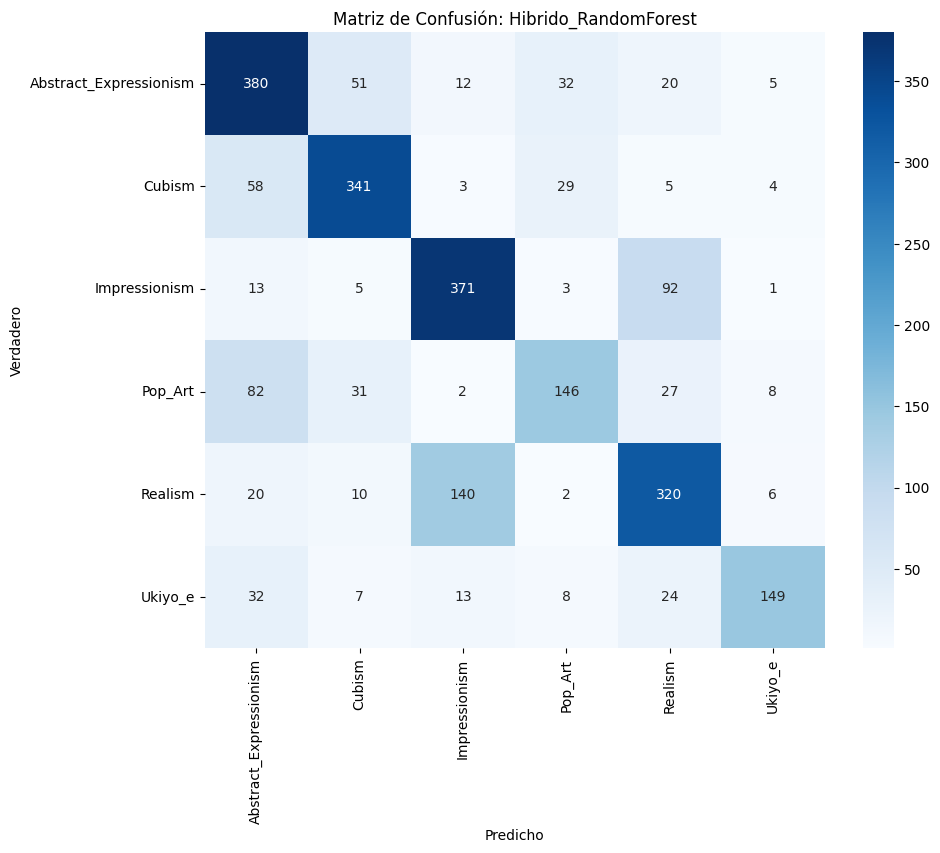


--- Reporte de Clasificación: Hibrido_RandomForest ---
                        precision    recall  f1-score   support

Abstract_Expressionism       0.65      0.76      0.70       500
                Cubism       0.77      0.78      0.77       440
         Impressionism       0.69      0.76      0.72       485
               Pop_Art       0.66      0.49      0.57       296
               Realism       0.66      0.64      0.65       498
               Ukiyo_e       0.86      0.64      0.73       233

              accuracy                           0.70      2452
             macro avg       0.71      0.68      0.69      2452
          weighted avg       0.70      0.70      0.69      2452

RandomForest: 0.6962


In [12]:
print(f"\nFASE 3: Modelos Hibridos (Usando '{nombre_final}' como extractor)")

# Crear extractor del modelo final
try:
    # Intentamos buscar la capa de pooling por nombre
    layer_name = None
    for layer in modelo_final_dl.layers:
        if 'global_average_pooling' in layer.name:
            layer_name = layer.name
            break
    
    # Crear extractor
    if layer_name:
        extractor = Model(
            inputs=modelo_final_dl.input, 
            outputs=modelo_final_dl.get_layer(layer_name).output
        )
    else:
        # Fallback: Usar la capa ante-penúltima (antes de los Dense)
        extractor = Model(
            inputs=modelo_final_dl.input, 
            outputs=modelo_final_dl.layers[-4].output
        )

    # Generadores Ordenados (CRUCIAL: shuffle=False)
    gen_train_feat = train_datagen.flow_from_directory(
        BASE_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        subset='training', 
        seed=SEED, 
        shuffle=False
    )
    gen_val_feat = train_datagen.flow_from_directory(
        BASE_DIR, 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode='categorical', 
        subset='validation', 
        seed=SEED, 
        shuffle=False
    )

    # Extracción de features
    X_train = extractor.predict(gen_train_feat, verbose=1)
    y_train = gen_train_feat.classes
    X_val = extractor.predict(gen_val_feat, verbose=1)
    y_val = gen_val_feat.classes

    # Entrenar Clásicos
    clasificadores = {
        'SVM_RBF': SVC(kernel='rbf', C=1.0),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=SEED)
    }

    # Entrenamiento y evaluación de cada clasificador
    for clf_name, clf in clasificadores.items():
        print(f"Entrenando {clf_name}")
        start_t = time.time()
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc_hibrido = accuracy_score(y_val, preds)
        dur = time.time() - start_t

        print(f"Resultados para {clf_name}:")
        mostrar_matriz_confusion(y_val, preds, class_names, f"Hibrido_{clf_name}")
        
        # Registro de resultados híbridos
        resultados_globales.append({
            'Modelo': f"Hibrido_{clf_name}_({nombre_final})", 
            'Etapa': '3. Híbrido', 
            'Accuracy': acc_hibrido, 
            'Tiempo': dur
        })
        print(f"{clf_name}: {acc_hibrido:.4f}")

# Mostrar resultados globales
except Exception as e:
    print(f"Error en fase híbrida: {e}")

Resumen Final del Proyecto


,Modelo,Etapa,Accuracy,Tiempo
0,resnet50_FineTuned,2. Optimización,0.721452,5062.473804
1,Hibrido_SVM_RBF_(resnet50_FineTuned),3. Híbrido,0.705954,87.416688
2,Hibrido_RandomForest_(resnet50_FineTuned),3. Híbrido,0.696166,37.628516
3,resnet50_Base,1. Selección,0.662724,5446.825012
4,mobilenet_Base,1. Selección,0.637439,4083.920980
5,vgg16_Base,1. Selección,0.538336,5417.269582


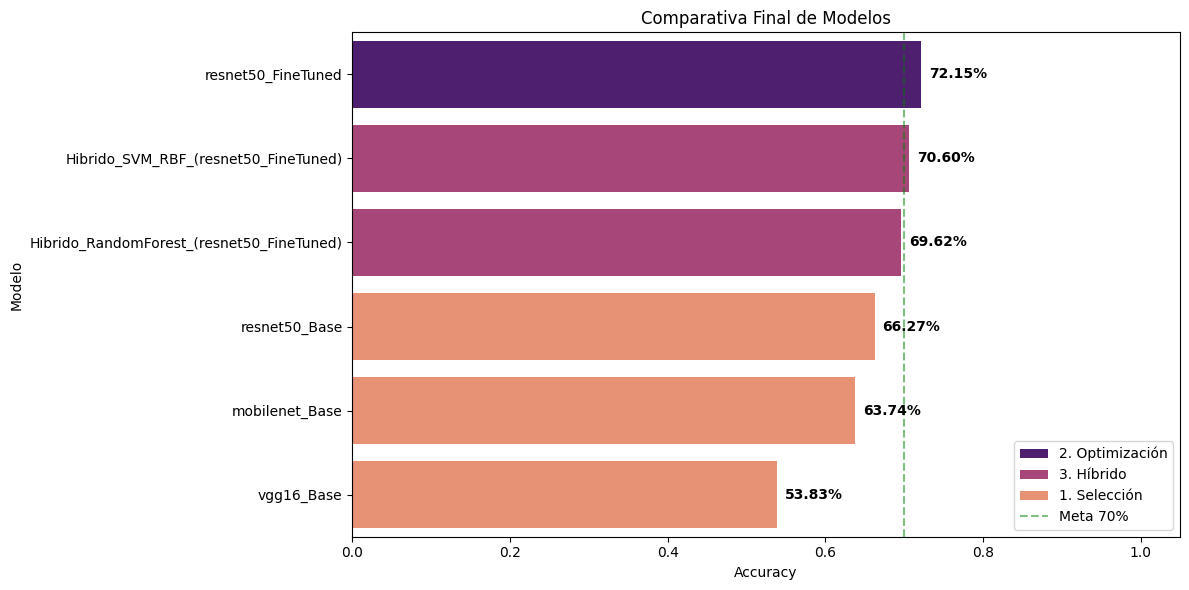

MEJOR MODELO: resnet50_FineTuned con 72.15%


In [13]:
print("Resumen Final del Proyecto")

# Crear DataFrame
df_final = pd.DataFrame(resultados_globales)

#df_final = df_final.drop_duplicates(subset=['Modelo'], keep='last') # Eliminar duplicados

# Ordenar por precisión
df_final = df_final.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Mostrar Tabla
display(df_final)

# Gráfico de Barras Limpio
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Accuracy', 
    y='Modelo', 
    data=df_final, 
    hue='Etapa', 
    palette='magma', 
    dodge=False
)
plt.title('Comparativa Final de Modelos')
plt.xlim(0, 1.05) # Un poco mas de espacio
plt.axvline(
    x=0.7, 
    color='green', 
    linestyle='--', 
    alpha=0.5, 
    label='Meta 70%'
)

# Poner los valores en las barras
for index, row in df_final.iterrows():
    plt.text(
        row['Accuracy'] + 0.01, index, 
        f"{row['Accuracy']:.2%}", 
        va='center', 
        fontweight='bold'
    )

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f"MEJOR MODELO: {df_final.iloc[0]['Modelo']} con {df_final.iloc[0]['Accuracy']:.2%}")